# California Housing Prices

In this notebook, we analyzed a set of data consisting of median house prices for California. Using the data we obtained predicted error values.

## Initial Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats

## Read CSV and Perform Basic Data Cleaning

In [2]:
# Load the data
file_path = Path('Resources/california_housing_prices.csv')
df = pd.read_csv(file_path)

# Preview the data
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [3]:
# Drop nulls
df = df.dropna().copy()
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# Get a summary of all features in the data and their types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


In [5]:
# To see how many subsets there are in "Ocean Proximity" column
df.ocean_proximity.value_counts()

<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: ocean_proximity, dtype: int64

<AxesSubplot:>

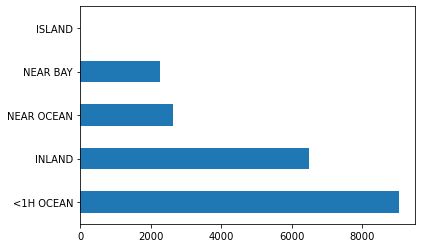

In [6]:
df.ocean_proximity.value_counts().sort_values(ascending=False).plot.barh()

In [7]:
# Descriptive statistics
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

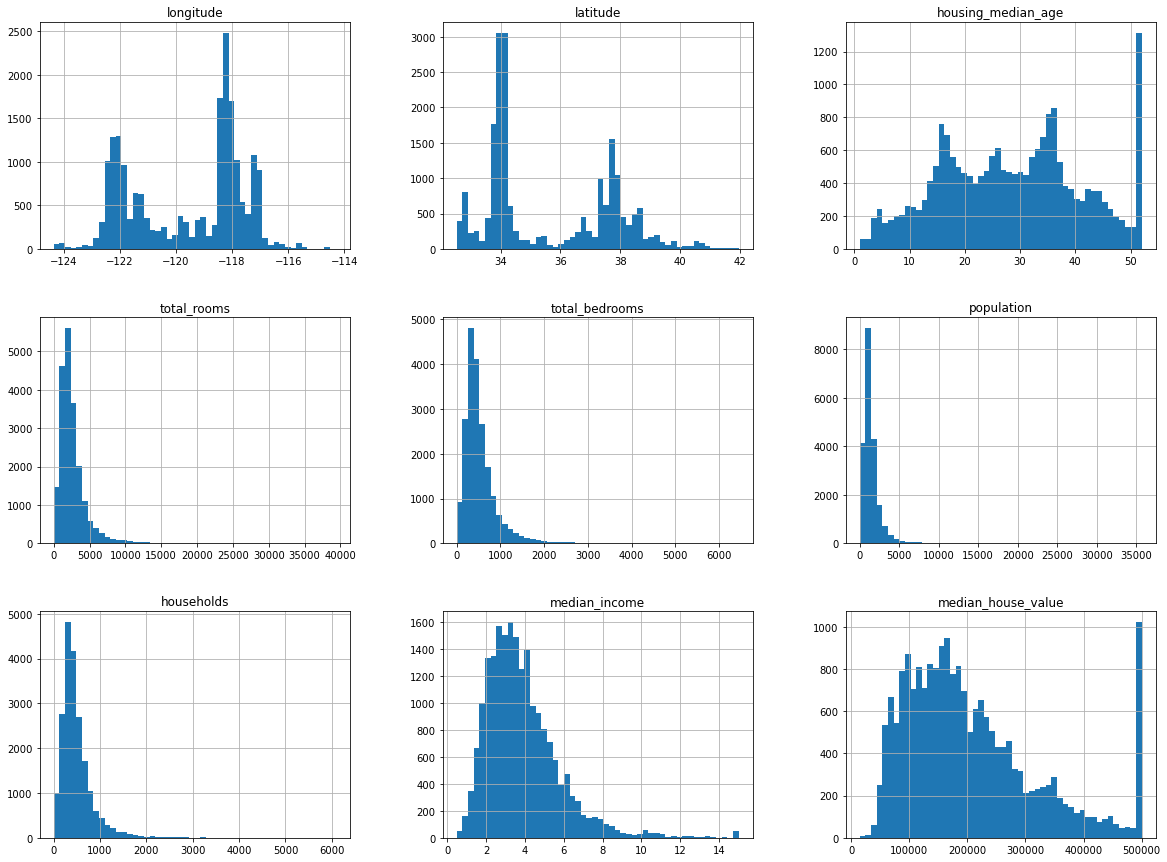

In [8]:
# Plotting a histogram for each numerical attribute
df.hist(bins=50, figsize=(20,15))

<AxesSubplot:title={'center':'Visualizing Geographical Data'}, xlabel='longitude', ylabel='latitude'>

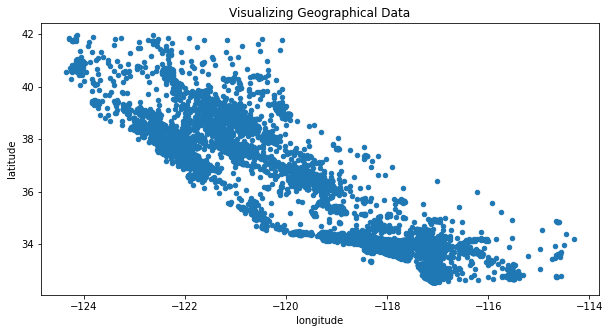

In [9]:
# Visualizing Geographical Data
df.plot(kind='scatter', x='longitude', y='latitude', figsize=(10,5), title= 'Visualizing Geographical Data')

<AxesSubplot:>

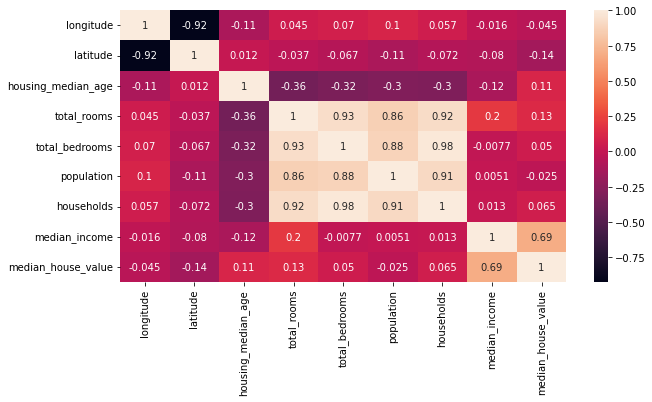

In [10]:
# Exploring the correlations in the data set
plt.figure(figsize=(10, 5))
sns.heatmap(df.corr(), annot=True)

#### Filling in missing values

In [11]:
# Return the number of missing values in each column
df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [12]:
# Replace the null values with an average specified value
df['total_bedrooms'].fillna(df['total_bedrooms'].mean(),inplace=True)

In [13]:
num_imputer = SimpleImputer(strategy = 'mean')

imputer = ColumnTransformer([('num_imputer',num_imputer,['total_bedrooms'])])

total_bedrooms= imputer.fit_transform(df)

In [14]:
df['total_bedrooms'] = total_bedrooms

total_bedrooms

array([[ 129.],
       [1106.],
       [ 190.],
       ...,
       [ 485.],
       [ 409.],
       [ 616.]])

In [15]:
# Correlations
df_correlations = df.corr()
df_correlations

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924616,-0.109357,0.045480,0.069608,0.100270,0.056513,-0.015550,-0.045398
latitude,-0.924616,1.000000,0.011899,-0.036667,-0.066983,-0.108997,-0.071774,-0.079626,-0.144638
housing_median_age,-0.109357,0.011899,1.000000,-0.360628,-0.320451,-0.295787,-0.302768,-0.118278,0.106432
total_rooms,0.045480,-0.036667,-0.360628,1.000000,0.930380,0.857281,0.918992,0.197882,0.133294
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.100270,-0.108997,-0.295787,0.857281,0.877747,1.000000,0.907186,0.005087,-0.025300
households,0.056513,-0.071774,-0.302768,0.918992,0.979728,0.907186,1.000000,0.013434,0.064894
median_income,-0.015550,-0.079626,-0.118278,0.197882,-0.007723,0.005087,0.013434,1.000000,0.688355
median_house_value,-0.045398,-0.144638,0.106432,0.133294,0.049686,-0.025300,0.064894,0.688355,1.000000


In [16]:
df_correlations['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688355
total_rooms           0.133294
housing_median_age    0.106432
households            0.064894
total_bedrooms        0.049686
population           -0.025300
longitude            -0.045398
latitude             -0.144638
Name: median_house_value, dtype: float64

In [17]:
# Create new features and check their correlations
df['rooms_per_house'] = df['total_rooms']/df['households']
df['population_per_house'] = df['population']/df['households']

In [18]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_house,population_per_house
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,8.288136,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5.817352,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6.281853,2.181467


In [19]:
df_corr = df.corr()
df_corr['median_house_value'].sort_values(ascending=False)

median_house_value      1.000000
median_income           0.688355
rooms_per_house         0.151344
total_rooms             0.133294
housing_median_age      0.106432
households              0.064894
total_bedrooms          0.049686
population_per_house   -0.023639
population             -0.025300
longitude              -0.045398
latitude               -0.144638
Name: median_house_value, dtype: float64

In [20]:
# Category variable
ocean_prox = pd.get_dummies(df['ocean_proximity'])
ocean_prox.head()

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


In [21]:
# Combining dataframe and variable
df = pd.concat([df, ocean_prox],axis = 1)
df.drop('ocean_proximity',axis = 1, inplace = True)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_house,population_per_house,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,6.984127,2.555556,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,6.238137,2.109842,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,8.288136,2.802260,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,5.817352,2.547945,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,6.281853,2.181467,0,0,0,1,0


## Split the Data into Training and Testing

In [22]:
# Create features
X = df.drop('median_house_value', axis=1)

# Create target vector
y = df['median_house_value']

In [23]:
# Check the balance of our target values
y.value_counts()

500001.0    958
137500.0    119
162500.0    116
112500.0    103
187500.0     92
           ... 
359200.0      1
51200.0       1
39800.0       1
377600.0      1
47000.0       1
Name: median_house_value, Length: 3833, dtype: int64

In [24]:
# Split the X and y into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42
)

X_train.shape

(16346, 15)

In [25]:
# Use the MinMaxScaler to scale data between 0 and 1
scaler = MinMaxScaler()


# Fitting MinMaxScaler instance
X = scaler.fit_transform(X)
X[0:5]

array([[0.21115538, 0.5674814 , 0.78431373, 0.02233074, 0.01986344,
        0.00894083, 0.02055583, 0.53966842, 0.0435123 , 0.00149943,
        0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.21215139, 0.565356  , 0.39215686, 0.18050257, 0.17147734,
        0.0672104 , 0.18697583, 0.53802706, 0.03822395, 0.00114074,
        0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.21015936, 0.5642933 , 1.        , 0.03726029, 0.02932961,
        0.01381765, 0.02894261, 0.46602805, 0.05275646, 0.00169796,
        0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.20916335, 0.5642933 , 1.        , 0.03235159, 0.03631285,
        0.01555537, 0.03584937, 0.35469856, 0.03524099, 0.0014933 ,
        0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.20916335, 0.5642933 , 1.        , 0.04132967, 0.04329609,
        0.01575156, 0.04242723, 0.23077613, 0.03853386, 0.00119838,
        0.        , 0.        , 0.        , 

## Model Evaluation

#### Evaluating metrics with Cross Validation

In [26]:
def score_display(scores):
    scores = np.sqrt(-scores)
    print(f"""
    RMSE Scores : {scores}
    Mean : {scores.mean()}
    Standart Deviation : {scores.std()}
    """)

In [27]:
linreg = LinearRegression()
DecTree = DecisionTreeRegressor()
RandForest = RandomForestRegressor()
SVM = SVR()

In [28]:
# Linear Regression
linreg_scores = cross_val_score(
    linreg,
    X_train,
    y_train,
    scoring = 'neg_mean_squared_error',
    cv=10
)

score_display(linreg_scores)


    RMSE Scores : [64830.50509793 64175.85105171 69790.27101042 70932.88243843
 67861.85460263 66611.02576017 74546.70220894 70395.83190835
 67758.68894349 69205.53097226]
    Mean : 68610.91439943455
    Standart Deviation : 2912.107632857478
    


In [29]:
# Decision Tree
DecTree_scores = cross_val_score(
    DecTree,
    X_train,
    y_train,
    scoring = 'neg_mean_squared_error',
    cv=10
)

score_display(DecTree_scores)


    RMSE Scores : [70089.99029714 67243.79266541 78907.58548079 75316.45789121
 67975.00922982 67520.65513251 68324.4129749  71840.12490212
 70873.93020732 71479.6178662 ]
    Mean : 70957.1576647426
    Standart Deviation : 3541.85665918769
    


In [30]:
# Random Forest
RandForest_scores = cross_val_score(
    RandForest,
    X_train,
    y_train,
    scoring = 'neg_mean_squared_error',
    cv=10
)

score_display(RandForest_scores)

In [ ]:
# Support Vector Machine
SVM_scores = cross_val_score(
    SVM,
    X_train,
    y_train,
    scoring = 'neg_mean_squared_error',
    cv=10
)

score_display(SVM_scores)


    RMSE Scores : [119094.47159265 121011.36551495 119205.7932461  114116.91854659
 117888.00142989 119295.72248473 115643.65508969 116473.4672355
 119250.75317175 119797.05656486]
    Mean : 118177.72048767065
    Standart Deviation : 2021.1507462108714
    


RandomForest has the lowest Root Mean Squared Error.

## Parameter Optimization

#### GridSearchCV

Helps to loop through predefined hyperparameters and fit your estimator (model) on your training set. So, in the end, you can select the best parameters from the listed hyperparameters.

In [ ]:
params = {
    'n_estimators': [3, 10, 20, 50], 
    'max_features': [2, 3, 4, 10]
}

In [ ]:
grid_search = GridSearchCV(
    RandForest,
    params, 
    cv=5,
    scoring='neg_mean_squared_error'
)

In [ ]:
# Fitting data into GridSearchCV
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [2, 3, 4, 10],
                         'n_estimators': [3, 10, 20, 50]},
             scoring='neg_mean_squared_error')

In [ ]:
# Best results on the held out data
grid_search.best_params_

{'max_features': 4, 'n_estimators': 50}

In [ ]:
for mean_score,params in zip(
    (grid_search.cv_results_['mean_test_score']),
    (grid_search.cv_results_['params'])
):    
    
    print(np.sqrt(-mean_score),'    ',params)

62723.02369655602      {'max_features': 2, 'n_estimators': 3}
54405.71548304711      {'max_features': 2, 'n_estimators': 10}
52832.00266799951      {'max_features': 2, 'n_estimators': 20}
51443.69218897462      {'max_features': 2, 'n_estimators': 50}
60328.847592393395      {'max_features': 3, 'n_estimators': 3}
52702.07586430306      {'max_features': 3, 'n_estimators': 10}
51140.40745750642      {'max_features': 3, 'n_estimators': 20}
49885.68295335053      {'max_features': 3, 'n_estimators': 50}
59540.62954414431      {'max_features': 4, 'n_estimators': 3}
52426.23644444778      {'max_features': 4, 'n_estimators': 10}
50369.44301587852      {'max_features': 4, 'n_estimators': 20}
49264.972302367205      {'max_features': 4, 'n_estimators': 50}
58567.60533232593      {'max_features': 10, 'n_estimators': 3}
52194.62322344519      {'max_features': 10, 'n_estimators': 10}
50799.83543166272      {'max_features': 10, 'n_estimators': 20}
49515.87862612662      {'max_features': 10, 'n_estimat

In [ ]:
# Making predictions using the best estimator
predictions = grid_search.best_estimator_.predict(X_test)

In [ ]:
y_test[0:10].values

array([ 47700.,  45800., 500001., 218600., 278000., 158700., 198200.,
       157500., 340000., 446600.])

In [ ]:
# Comparing real versus predicted values
comparison = pd.DataFrame(
    {'Y Test': y_test[0:10].values,
    'Predictions' : predictions[0:10]}
)
comparison

,Y Test,Predictions
0,47700.0,50062.00
1,45800.0,75156.00
2,500001.0,468098.62
3,218600.0,254798.00
4,278000.0,230156.00
5,158700.0,153612.00
6,198200.0,229394.02
7,157500.0,172942.00
8,340000.0,297786.06
9,446600.0,471484.56


<AxesSubplot:title={'center':'Real vs Predicted Values'}>

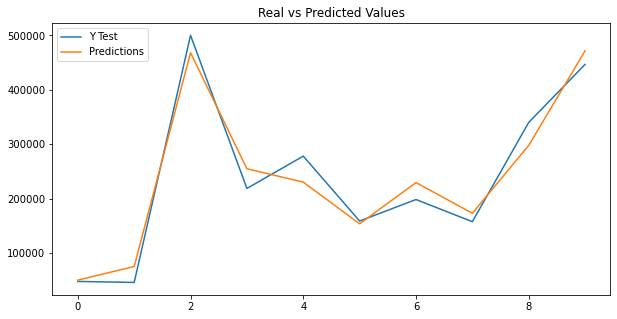

In [ ]:
# Plot the real vs predicted values as a line chart
comparison.plot(title= 'Real vs Predicted Values', figsize= (10,5))

## Evaluations

In [ ]:
def regression_evaluation(preds):
    mse = mean_squared_error(y_test,preds)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_test,preds)
    mae = mean_absolute_error(y_test,preds)
    
    print(f"Mean Absolute Error: {mae} \nMean Squared Error:{mse} \nRoot Mean Squared Error:{rmse} \nR Squared Value:{r_squared}")

In [ ]:
regression_evaluation(predictions)

Mean Absolute Error: 32110.13673449612 
Mean Squared Error:2386841599.041903 
Root Mean Squared Error:48855.312904963605 
R Squared Value:0.8178552162969752


## Confidence Interval

In [ ]:
# Finding the Confidence Interval Of 95%
confidence = 0.95
squared_errors = (predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
loc=squared_errors.mean(),
scale=stats.sem(squared_errors))) 

array([46656.44259578, 50959.3913071 ])

The model can predict with the error values between 46,656.44 and 50,959.39.